In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import MNIST
from torchvision import transforms
import torchvision
import pytorch_lightning as pl

In [2]:
import random
import numpy as np
import torch
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.utils.data import ConcatDataset
import os

class RotationTransform:

    def __init__(self, angles):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return TF.rotate(x, angle)

def get_dataset(root, input_size=224):

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    rotate = RotationTransform(angles=[0, 180, 90, 270])

    train_dataset = ImageFolder(os.path.join(root, 'train'),
                        transforms.Compose([
                        transforms.Resize((input_size, input_size)),
                        transforms.RandomHorizontalFlip(),
                        rotate,
                        transforms.ToTensor(),
                        normalize,
                    ]))

    val_dataset = ImageFolder(os.path.join(root, 'valid'),
                        transforms.Compose([
                        transforms.Resize((input_size, input_size)),
                        transforms.ToTensor(),
                        normalize,
                    ]))
    
    return train_dataset, val_dataset

def get_concat_dataset(input_size=128):

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    rotate = RotationTransform(angles=[0, 180, 90, 270])

    train_dataset = ImageFolder("/opt/ml/data/train",
                        transforms.Compose([
                        transforms.Resize((input_size, input_size)),
                        transforms.RandomHorizontalFlip(),
                        rotate,
                        transforms.ToTensor(),
                        normalize,
                    ]))

    valid_dataset = ImageFolder("/opt/ml/data/val",
                        transforms.Compose([
                        transforms.Resize((input_size, input_size)),
                        transforms.RandomHorizontalFlip(),
                        rotate,
                        transforms.ToTensor(),
                        normalize,
                    ]))
    
    return ConcatDataset([train_dataset, valid_dataset])

In [3]:
class ConfusionMatrix:
    """
    T  8  3  6  2
    R  5  9  3  9
    U  0  3  1  4
    E  0  9  9  5
       P  R  E  D
    """
    
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.conf_mtx = np.zeros((num_classes, num_classes), dtype=int)
        
    def accumulate(self, y_pred, y_true):
        self.conf_mtx += np.bincount(y_true * self.num_classes + y_pred, minlength=self.num_classes**2).reshape((self.num_classes, self.num_classes))
        
    def accuracy(self):
        return np.diag(self.conf_mtx).sum() / self.conf_mtx.sum()
    
    def f1_score(self):
        tp = np.diag(self.conf_mtx)
        precision = tp / np.sum(self.conf_mtx, axis=0)
        recall = tp / np.sum(self.conf_mtx, axis=1)
        f1_score = 2 * precision * recall / (precision + recall)
        return np.mean(f1_score)

    def reset(self):
        self.conf_mtx.fill(0)

In [4]:
from pytorch_lightning.callbacks import Callback


class Metric(Callback):
    
    def on_train_start(self, trainer, pl_module):
        print(pl_module.conf_mtx)

#     def on_train_epoch_end(self, trainer, pl_module):
#         for opt_idx, optimizer in enumerate(trainer.optimizers):
#             old_lr_group = self.old_lrs[opt_idx]
#             new_lr_group = []
#             for p_idx, param_group in enumerate(optimizer.param_groups):
#                 old_lr = old_lr_group[p_idx]
#                 new_lr = old_lr * 0.98
#                 new_lr_group.append(new_lr)
#                 param_group["lr"] = new_lr
#             self.old_lrs[opt_idx] = new_lr_group
            
# class DecayLearningRate(Callback):
#     def __init__(self):
#         self.old_lrs = []

#     def on_train_start(self, trainer, pl_module):
#         # track the initial learning rates
#         for opt_idx, optimizer in enumerate(trainer.optimizers):
#             group = [param_group["lr"] for param_group in optimizer.param_groups]
#             self.old_lrs.append(group)

#     def on_train_epoch_end(self, trainer, pl_module):
#         for opt_idx, optimizer in enumerate(trainer.optimizers):
#             old_lr_group = self.old_lrs[opt_idx]
#             new_lr_group = []
#             for p_idx, param_group in enumerate(optimizer.param_groups):
#                 old_lr = old_lr_group[p_idx]
#                 new_lr = old_lr * 0.98
#                 new_lr_group.append(new_lr)
#                 param_group["lr"] = new_lr
#             self.old_lrs[opt_idx] = new_lr_group

In [5]:
class LitModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet50(pretrained=True)
        self.model.fc = nn.Linear(2048, 5)
        self.criterion = nn.CrossEntropyLoss()
        self.train_conf_mtx = ConfusionMatrix(5)
        self.val_conf_mtx = ConfusionMatrix(5)

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-5)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        imgs, labels = train_batch
        probs = self.model(imgs)
        preds = torch.argmax(probs, axis=1)
        loss = self.criterion(probs, labels)
        
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        
        preds, labels = preds.cpu().numpy(), labels.cpu().numpy()
        self.train_conf_mtx.accumulate(preds, labels)
        
        return loss

    def on_train_epoch_end(self):
        self.log('train_acc', self.train_conf_mtx.accuracy(), on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_f1', self.train_conf_mtx.f1_score(), on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.train_conf_mtx.reset()

    def validation_step(self, val_batch, batch_idx):
        imgs, labels = val_batch
        probs = self.model(imgs)
        preds = torch.argmax(probs, axis=1)
        loss = self.criterion(probs, labels)       
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        
        preds, labels = preds.cpu().numpy(), labels.cpu().numpy()
        self.val_conf_mtx.accumulate(preds, labels)
        
    def on_validation_epoch_end(self):
        self.log('valid_acc', self.val_conf_mtx.accuracy(), on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('valid_f1', self.val_conf_mtx.f1_score(), on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.val_conf_mtx.reset()

In [6]:
# data
#dataset = MNIST('', train=True, download=True, transform=transforms.ToTensor())
train_dataset, valid_dataset = get_dataset('/opt/ml/data_project')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8, drop_last=True)
val_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=8, drop_last=False)

In [7]:
len(train_dataset), len(valid_dataset)

(69434, 8679)

In [8]:
# model
model = LitModel()

# training
# trainer = pl.Trainer(gpus=1, limit_train_batches=0.25)
# trainer.fit(model, train_loader, val_loader)

In [239]:
torch.save(model.model.state_dict(), 'resnet50.pt')

In [9]:
model.load_from_checkpoint('/opt/ml/project/lightning_logs/version_1/checkpoints/epoch=78-step=42817.ckpt')

LitModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [10]:
img_transform = torchvision.transforms.Compose([torchvision.transforms.Resize((224,224)), #, torchvision.transforms.CenterCrop(224),
                                           torchvision.transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [11]:
from glob import glob
import PIL
import random

In [343]:
np.bincount(valid_dataset.targets), train_dataset.classes

(array([2141, 2269, 2478,  539, 1252]),
 ['one', 'onep', 'onepp', 'three', 'two'])

In [385]:
label_name = 'onep'

tot = 0
correct = 0

imgs = glob(f'/opt/ml/data_project/valid/{label_name}/*')

conf_mtx = ConfusionMatrix(5)

with torch.no_grad():
    for img, label in val_loader:
        img, label = img.to('cuda'), label.to('cuda')
        pred = torch.argmax(model(img), 1)
        pred, label = pred.cpu().numpy(), label.cpu().numpy()
        conf_mtx.accumulate(pred, label)        

In [386]:
conf_mtx.conf_mtx

array([[1628,  288,  175,    0,   50],
       [  20, 2138,   88,    1,   22],
       [  24,   83, 2323,    0,   48],
       [   3,   14,    5,  507,   10],
       [  66,  110,   49,    3, 1024]])

In [389]:
conf_mtx.accuracy()

0.8779813342550985

In [307]:
for label, label_name in enumerate(['1', '1+', '1++', '3', '2']):
    
    print(label_name)
    
    imgs = glob(f'test_imgs/{label_name}/*')
    #print(imgs)
    model.eval()

    tot = len(imgs)
    correct = 0

    with torch.no_grad():
        for img_path in imgs:
            try:
                img = PIL.Image.open(img_path)
                img = img_transform(img).unsqueeze(0).cuda()
                pred = torch.softmax(model(img), dim=1)
                if torch.argmax(pred).item() == label:
                    correct += 1
                print(img_path, train_dataset.classes[torch.argmax(pred).item()])
            except:
                tot -= 1
                print(img_path, 'err')

    print('\n', correct/tot)
    print()

1
test_imgs/1/20211213_151532.jpg onepp
test_imgs/1/20211213_151719.jpg onepp
test_imgs/1/15.jpg onepp
test_imgs/1/17.jpg two
test_imgs/1/8.jpg two
test_imgs/1/3.jpg two
test_imgs/1/2.jpg two
test_imgs/1/20211213_151527.jpg onepp
test_imgs/1/20211213_151542.jpg onepp
test_imgs/1/16.jpg two
test_imgs/1/20211213_151736.jpg onepp
test_imgs/1/1sdfs.jpg one
test_imgs/1/18.jpg two
test_imgs/1/11.jpg two
test_imgs/1/6.jpg onepp
test_imgs/1/12.jpeg onepp
test_imgs/1/20211213_151726.jpg onepp
test_imgs/1/13.jpg onepp
test_imgs/1/20211213_151520.jpg two
test_imgs/1/9.jpg onepp
test_imgs/1/5.jpg two
test_imgs/1/20211213_151547.jpg onepp
test_imgs/1/7.jpg two
test_imgs/1/19.jpg onepp
test_imgs/1/4.jpg two
test_imgs/1/10.jpg one
test_imgs/1/14.jpg onepp
test_imgs/1/20.jpg two

 0.07142857142857142

1+
test_imgs/1+/8.jpeg onepp
test_imgs/1+/2.jpeg one
test_imgs/1+/1.jpg onepp
test_imgs/1+/12.jpg two
test_imgs/1+/3.jpeg two
test_imgs/1+/11.jpg onepp
test_imgs/1+/6.jpg onepp
test_imgs/1+/13.jpg two
te

In [208]:
img = PIL.Image.open('test_imgs/2.jpeg')
img = img_transform(img).unsqueeze(0).cuda()

In [209]:
with torch.no_grad():
    pred = torch.softmax(model(img), dim=1)
pred

tensor([[3.8317e-03, 4.3346e-03, 1.3926e-01, 1.1318e-08, 8.5257e-01]],
       device='cuda:0')

In [174]:
train_dataset.classes

['one', 'onep', 'onepp', 'three', 'two']

In [12]:
model.eval()
print()

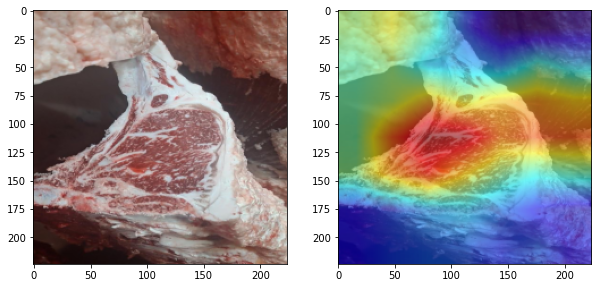

In [71]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2
from skimage.transform import resize

target_layers = [model.model.layer4[-1]]


with GradCAM(model=model, target_layers=target_layers, use_cuda=True) as cam:
    
    folder_path = '/opt/ml/data_project/train/one/*'
    
    imgs = glob(folder_path) #glob(f'test_imgs/1/*')
    img_path = random.choice(imgs)
    img = PIL.Image.open(img_path)
    rgb_img = np.array(img, dtype=np.float32) / 255.0
    rgb_img = resize(rgb_img, (224, 224))
    img = img_transform(img).unsqueeze(0).cuda()

    input_tensor = img
    target_category = None
    
    grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)

    grayscale_cam = grayscale_cam[0, :]

    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

fig, axes = plt.subplots(1, 2, figsize=(10,6))
axes[0].imshow(rgb_img)
axes[1].imshow(visualization)